In [1]:
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms as T
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL
import random
from time import time
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# 设置随机种子
seed = 42
torch.manual_seed(seed)
random.seed(seed)

cuda


In [2]:
class PascalVOC(torch.utils.data.Dataset):
    """PASCAL VOC 2007 + 2012 数据集"""
    def __init__(self, train=True, image_sizes=None):
        super().__init__()
        self.train = train
        self.data07 = torchvision.datasets.VOCDetection(root='../data',
                                                      year='2007',
                                                      image_set='train' if train else 'val',
                                                      download=False)
        self.data12 = torchvision.datasets.VOCDetection(root='../data',
                                                      year='2012',
                                                      image_set='train' if train else 'val',
                                                      download=False)
        self.trans_train = T.Compose([T.ToTensor(),
                                      T.ColorJitter(brightness=0.2,
                                                    contrast=0.2,
                                                    saturation=0.2,
                                                    hue=0.1),
                                      T.Normalize(mean=[0.4541, 0.4336, 0.4016],
                                                   std=[0.2396, 0.2349, 0.2390],)])
        self.trans_valid = T.Compose([T.ToTensor(),
                                      T.Normalize(mean=[0.4541, 0.4336, 0.4016],
                                                   std=[0.2396, 0.2349, 0.2390],)])
        self.cls_labels = ['person',
                           'bird', 'cat', 'cow', 'dog', 'horse', 'sheep',
                           'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train',
                           'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor']
        if image_sizes is not None:
            self.img_sizes = image_sizes
        else:
            self.img_sizes = [i * 32 + 320 for i in range(10)]
        self.current_shape = None
        self.random_size()
        assert self.current_shape is not None
        
    def __len__(self):
        return len(self.data07) + len(self.data12)
    
    def random_size(self):
        self.current_shape = self.img_sizes[random.randint(0, len(self.img_sizes) - 1)]
        return self.current_shape
    
    def Resize(self, image, box_coords, size):
        if isinstance(size, (int, float)):
            size = (int(size), int(size))
        h, w = image.size[1], image.size[0]
        resize_ratio = (size[0] / w, size[1] / h)
        image = T.Resize(size)(image)
        box_coords[:, 0::2] = (box_coords[:, 0::2] * resize_ratio[0]).int()
        box_coords[:, 1::2] = (box_coords[:, 1::2] * resize_ratio[1]).int()
        return image, box_coords
    
    def __getitem__(self, index):
        data = self.data07 if index < len(self.data07) else self.data12
        index = index if index < len(self.data07) else index - len(self.data07)
        image = data[index][0]
        box_labels, box_coords = self.get_label_list(data[index][1])
        if self.train:
            image, box_coords = self.Resize(image, box_coords, self.current_shape)
            image, box_coords = self.RandomHorizontalFlip(image, box_coords)
            image = self.trans_train(image)
        else:
            image, box_coords = self.Resize(image, box_coords, 416)
            image = self.trans_valid(image)
        return image, torch.cat((torch.zeros_like(box_labels, dtype=int),
                                    box_labels, box_coords), dim=1)
    
    def get_label_list(self, label):
        obj_list = label['annotation']['object']
        box_labels = [self.cls_labels.index(obj['name'] if type(obj['name']) == str else obj['name'][0]) for obj in obj_list]
        box_coords = []
        for obj in obj_list:
            coord = []
            for k in ['xmin', 'ymin', 'xmax', 'ymax']:
                v = obj['bndbox'][k]
                coord.append(int(v if type(v) == str else v[0]))
            box_coords.append(coord)
        return (torch.tensor(box_labels)[:, None], torch.tensor(box_coords))

    def RandomHorizontalFlip(self, image, box_coords):
        if random.random() > 0.5:
            w = image.size[0]
            image = T.RandomHorizontalFlip(p=1)(image)
            x1, x2 = box_coords[:, 0], box_coords[:, 2]
            box_coords[:, 0], box_coords[:, 2] = w - x2, w - x1
        return image, box_coords

In [3]:
def collate(batch):
    image, labels = zip(*batch)
    image = torch.stack(image, 0)
    for i, label in enumerate(labels):
        label[:, 0] = i
    return image, torch.cat(labels, 0)

In [4]:
voc_train = PascalVOC(train=True)
voc_val = PascalVOC(train=False)

In [5]:
def refine_box(box_cxcywh, shift):
    """使用偏移系数修正锚框/候选框，输入输出皆为cxcywh格式"""
    box = box_cxcywh.to(shift.device)
    p_cx = box[:, 2] * shift[:, 0] + box[:, 0]
    p_cy = box[:, 3] * shift[:, 1] + box[:, 1]
    p_w = box[:, 2] * torch.exp(shift[:, 2])
    p_h = box[:, 3] * torch.exp(shift[:, 3])
    return torch.stack([p_cx, p_cy, p_w, p_h], dim=1)

def coord_to_shift(src_cxcywh, tgt_cxcywh):
    """使用源框和目标框计算从源框到目标框的偏移系数"""
    assert src_cxcywh.shape == tgt_cxcywh.shape
    t_x = (tgt_cxcywh[:, 0] - src_cxcywh[:, 0]) / src_cxcywh[:, 2]
    t_y = (tgt_cxcywh[:, 1] - src_cxcywh[:, 1]) / src_cxcywh[:, 3]
    t_w = torch.log(tgt_cxcywh[:, 2] / src_cxcywh[:, 2])
    t_h = torch.log(tgt_cxcywh[:, 3] / src_cxcywh[:, 3])
    return torch.stack([t_x, t_y, t_w, t_h], dim=1)

# 边界框格式转换
def cxcywh2xyxy(boxes):
    return torchvision.ops.box_convert(boxes, 'cxcywh', 'xyxy').int()
def xyxy2cxcywh(boxes):
    return torchvision.ops.box_convert(boxes, 'xyxy', 'cxcywh').int()

# 固定/解除固定模型参数
def freeze(module):
    for param in module.parameters():
        param.requires_grad_(False)
def unfreeze(module):
    for param in module.parameters():
        param.requires_grad_(True)

# 
def batched_nms(boxes, # 预测框集合[N, 4]
                scores, # 预测框对应类别的置信度
                idxs, # 预测框对应类别
                iou_thres # IOU阈值，与置信度最高的预测框的IOU高于此阈值的同类别预测框会被丢弃
                ):
    """
    逐类进行非极大值抑制
    Args:
        boxes (Tensor): 预测框集合，形状为[N, 4]
        scores (Tensor): 预测框对应类别的置信度，形状为[N]
        idxs (Tensor): 预测框对应类别，形状为[N]
        iou_thres (float): IOU阈值，与置信度最高的预测框的IOU高于此阈值的同类别预测框会被丢弃
    """
    keep_mask = torch.zeros_like(scores, dtype=torch.bool)
    for class_id in torch.unique(idxs):
        curr_indices = torch.where(idxs == class_id)[0]
        curr_keep_indices = torchvision.ops.nms(boxes[curr_indices], scores[curr_indices], iou_thres)
        keep_mask[curr_indices[curr_keep_indices]] = True
    keep_indices = torch.where(keep_mask)[0]
    return keep_indices[scores[keep_indices].sort(descending=True)[1]]

def init_weight(module):
    """递归初始化模型参数"""
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        nn.init.normal_(module.weight, std=0.01)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, (nn.Sequential, nn.ModuleList)):
        for m in module:
            init_weight(m)

In [6]:
def assign_pred_to_gt(pred,
                      gt,
                      pos_thres,
                      neg_thres,
                      allow_low_quality_matches=True):
    """
    按阈值将锚框/候选框分为正、负样本，并将正样本分配给真实边界框
    Args:
        pred (Tensor): 待分配的锚框，xyxy格式，形状为[N, 4]。
        gt (Tensor): 真实边界框，xyxy格式，形状为[M, 4]。
        pos_thres (float): 正样本IOU阈值，与某真实边界框IOU超过此阈值的
            锚框/候选框被标记为正样本。
        neg_thres (float, tuple): 负样本IOU阈值，与所有真实边界框最高IOU
            在此区间或低于此值的锚框/候选框被标记为正样本。
        allow_low_quality_matches (bool): 允许低IOU的匹配，保证每个真实边界框
            都存在至少一个锚框/候选框与之对应。
    """
    iou_table = torchvision.ops.box_iou(pred, gt)
    pos_pred_indices, pos_gt_indices = [], []
    max_values, max_indices = iou_table.max(dim=1)
    positive = max_values > pos_thres
    pos_pred_indices.append(torch.arange(0, pred.shape[0], 1, device=pred.device)[positive])
    pos_gt_indices.append(max_indices[positive])
    iou_table[positive] = -1 # 防止该锚框/候选框再次被选中成为正/负样本
    
    if allow_low_quality_matches:
        for i in range(gt.shape[0]): # 遍历所有真实边界框
            argmax = iou_table[:, i].argmax().reshape(1)
            if iou_table[argmax, i] > 0: # 已被选中过的锚框/候选框不参与本轮分配
                pos_pred_indices.append(argmax)
                pos_gt_indices.append(torch.tensor([i], device=pred.device))
                iou_table[argmax] = -1
    max_values, max_indices = iou_table.max(dim=1)
    if isinstance(neg_thres, float): # 若负样本IOU阈值为一小数
        negative = (max_values < neg_thres) & (max_values > 0.)
    elif isinstance(neg_thres, tuple): # 若负样本IOU阈值为一区间
        negative = (max_values < neg_thres[1]) & (max_values > neg_thres[0])
    neg_pred_indices = torch.arange(0, pred.shape[0], 1, device=pred.device)[negative]
    
    pos_pred_indices = torch.concat(pos_pred_indices)
    pos_gt_indices = torch.concat(pos_gt_indices)
    assert pos_pred_indices.unique().shape == pos_pred_indices.shape,\
        'there is at least one predicted box assigned to multiple ground truth boxes'
    return pos_pred_indices, pos_gt_indices, neg_pred_indices

In [7]:
def random_sampling(pos_pred_indices,
                    pos_gt_indices,
                    neg_pred_indices,
                    pred_xyxy,
                    pred_conf,
                    gt_xyxy,
                    gt_label,
                    neg_cls_target,
                    pos_ratio,
                    num_samples_per_image):
    """
    对assign_pred_to_gt分配的结果（正负样本集）按指定正样本比例和批量大小进行采样，
    Args:
        pos_pred_indices (Tensor): 被选中成为正样本的锚框/预测框的下标。
        pos_gt_indices (Tensor): 各个成为正样本的锚框/预测框对应的真实边界框。
        neg_pred_indices (Tensor): 被选中成为负样本的锚框/预测框的下标。
        pred_xyxy (Tensor): 全部候选框/锚框。
        pred_conf (Tensor): 网络在各个预测框/锚框（在各个类别上）的回归输出。
        gt_xyxy (Tensor): 真实边界框，xyxy格式。
        gt_label (Tensor): 各个真实边界框所属的类别编号。
        neg_cls_target (Tensor): 负样本对应的类别（背景类）编号。
        pos_ratio (float): 一个小批量中正样本占比上限。
        num_samples_per_image (int): 每张图片的样本个数。
    """
    # 采样正样本
    pos_indices = [i for i in range(len(pos_pred_indices))]
    random.shuffle(pos_indices)
    pos_indices = pos_indices[:int(num_samples_per_image * pos_ratio)]
    
    # 采样负样本
    neg_indices = [i for i in range(len(neg_pred_indices))]
    random.shuffle(neg_indices)
    # 正样本不够就用负样本补全 batch
    neg_indices = neg_indices[:max(num_samples_per_image-len(pos_indices),
                                   int(num_samples_per_image * (1 - pos_ratio)))]
    
    pos_pred_indices = pos_pred_indices[pos_indices]
    pos_gt_indices = pos_gt_indices[pos_indices]
    neg_pred_indices = neg_pred_indices[neg_indices]
    
    # 被选中成为正样本的锚框/候选框到其对应的真实边界框的偏移系数就是网络的回归目标
    pos_reg_target = coord_to_shift(xyxy2cxcywh(pred_xyxy)[pos_pred_indices],
                                    xyxy2cxcywh(gt_xyxy)[pos_gt_indices])
    
    # 网络在正负样本上输出的（各个类别的）置信度
    pos_cls_conf = pred_conf[pos_pred_indices]
    neg_cls_conf = pred_conf[neg_pred_indices]
    
    # 各个正样本对应的真实边界框的类别编号
    pos_cls_target = gt_label[pos_gt_indices]
    
    # 背景类类别编号
    neg_cls_target = torch.empty(neg_pred_indices.shape,
                                 device=pred_conf.device,
                                 dtype=int).fill_(neg_cls_target)
    
    # 正负样本的类别置信度和类别编号
    cls_conf = torch.concat([pos_cls_conf, neg_cls_conf])
    cls_target = torch.concat([pos_cls_target, neg_cls_target])
    return pos_reg_target, (cls_conf, cls_target), pos_pred_indices

In [8]:
class Focus(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, input):
        assert input.shape[-2] % 2 == 0 and input.shape[-1] % 2 == 0
        four_corners = torch.cat([input[:, :, i::2, j::2] for i in (0, 1) for j in (0, 1)], dim=1)
        return four_corners

In [9]:
class CBL(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU())

In [10]:
class Backbone(nn.Module):
    def __init__(self, backbone_name):
        super().__init__()
        module_dict = {
            'resnet18': (models.resnet18,
                         ['conv1', 'bn1', 'relu', 'maxpool',
                          'layer1', 'layer2', 'layer3'],
                         ['layer4']),
            'resnet34': (models.resnet34,
                         ['conv1', 'bn1', 'relu', 'maxpool',
                          'layer1', 'layer2', 'layer3'],
                         ['layer4']),
            'resnet50': (models.resnet50,
                         ['conv1', 'bn1', 'relu', 'maxpool',
                          'layer1', 'layer2', 'layer3'],
                         ['layer4']),
            'resnet101': (models.resnet101,
                          ['conv1', 'bn1', 'relu', 'maxpool',
                           'layer1', 'layer2', 'layer3'],
                          ['layer4']),
            'resnet152': (models.resnet152,
                          ['conv1', 'bn1', 'relu', 'maxpool',
                           'layer1', 'layer2', 'layer3'],
                          ['layer4']),
            'densenet121': (models.densenet121,
                            ['conv0', 'norm0', 'relu0', 'pool0',
                             'denseblock1', 'transition1', 'denseblock2', 'transition2', 'denseblock3'],
                            ['transition3', 'denseblock4', 'norm5']),
            'densenet161': (models.densenet161,
                            ['conv0', 'norm0', 'relu0', 'pool0',
                             'denseblock1', 'transition1', 'denseblock2', 'transition2', 'denseblock3'],
                            ['transition3', 'denseblock4', 'norm5']),
            'densenet169': (models.densenet169,
                            ['conv0', 'norm0', 'relu0', 'pool0',
                             'denseblock1', 'transition1', 'denseblock2', 'transition2', 'denseblock3'],
                            ['transition3', 'denseblock4', 'norm5']),
            'densenet201': (models.densenet201,
                            ['conv0', 'norm0', 'relu0', 'pool0',
                             'denseblock1', 'transition1', 'denseblock2', 'transition2', 'denseblock3'],
                            ['transition3', 'denseblock4', 'norm5']),
            'mobilenet_v3_small': (models.mobilenet_v3_small,
                                   ['0', '1', '2', '3', '4',
                                    '5', '6', '7', '8'],
                                   ['9', '10', '11', '12']),
            'mobilenet_v3_large': (models.mobilenet_v3_large,
                                   ['0', '1', '2', '3', '4', '5', '6',
                                    '7', '8', '9', '10', '11', '12'],
                                   ['13', '14', '15', '16'])
        }
        assert backbone_name in list(module_dict.keys())
        raw_backbone = module_dict[backbone_name][0](pretrained=True)._modules
        if backbone_name[:6] != 'resnet':
            raw_backbone = raw_backbone['features']._modules
        self.backbone_ds16 = nn.Sequential(*[raw_backbone[key] for key in module_dict[backbone_name][1]])
        self.backbone_ds2  = nn.Sequential(*[raw_backbone[key] for key in module_dict[backbone_name][2]])
        self.focus = Focus()
        
    def forward(self, input):
        out = self.backbone_ds16(input)
        out = torch.cat([self.focus(out), self.backbone_ds2(out)], dim=1)
        return out

In [11]:
class RPN(nn.Module):
    """区域提议网络（不含特征提取部分）。"""
    def __init__(self, in_channels, hidden_channels, num_layers, area, ratio, downsample_rate):
        super().__init__()
        self.conv = [CBL(in_channels, hidden_channels), ]
        for i in range(1, num_layers):
            self.conv.append(CBL(hidden_channels, hidden_channels))
        self.conv = nn.Sequential(*self.conv)
        
        self.area = area
        self.ratio = ratio
        self.num_boxes = len(area) * len(ratio)
        self.branch_reg = nn.Conv2d(hidden_channels, self.num_boxes * 4, kernel_size=1, stride=1, padding=0)
        self.branch_cls = nn.Conv2d(hidden_channels, self.num_boxes, kernel_size=1, stride=1, padding=0)
        self.boxes = [(self.area[i], self.ratio[j]) for i in range(len(self.area)) for j in range(len(self.ratio))]
        self.conv_downsample_rate = downsample_rate
        
        init_weight(self.conv)
        init_weight(self.branch_reg)
        init_weight(self.branch_cls)
    
    def forward(self, feature_map):
        """输入backbone CNN输出的特征图，输出每个位置上每个锚框的物体置信度和4个偏移系数。"""
        n = feature_map.shape[0]
        hidden = self.conv(feature_map)
        objectness = self.branch_cls(hidden)
        shift = self.branch_reg(hidden)
        return objectness.permute(0, 2, 3, 1).reshape(n, -1), shift.permute(0, 2, 3, 1).reshape(n, -1, 4)
    
    def generate_anchor(self, output_size):
        """给定backbone CNN输出的特征图尺寸[C * H * W]，生成H * W * self.num_boxes个锚框，cxcywh格式。"""
        wh = torch.zeros(self.num_boxes, 2, device=device)
        for k, (area, ratio) in enumerate(self.boxes):
            # 高宽比ratio = h / w
            w = int((area / ratio) ** 0.5)
            h = int(w * ratio)
            wh[k, 0] = w
            wh[k, 1] = h
        cx = torch.arange(0, output_size[-1], 1, device=device).reshape(1, output_size[-1], 1, 1)\
            * self.conv_downsample_rate + self.conv_downsample_rate // 2
        cy = torch.arange(0, output_size[-2], 1, device=device).reshape(output_size[-2], 1, 1, 1)\
            * self.conv_downsample_rate + self.conv_downsample_rate // 2
        anchors = torch.concat([cx.expand(output_size[-2], -1, self.num_boxes, -1),
                                cy.expand(-1, output_size[-1], self.num_boxes, -1),
                                wh.expand(output_size[-2], output_size[-1], -1, -1)], dim=-1)
        return anchors.reshape(-1, 4)
    
    def get_proposal(self, feature_map, iou_thres=1.0, num_proposals=300):
        """利用RPN输出的偏移系数和锚框坐标来对锚框进行修正得到候选框"""
        proposals = []
        with torch.no_grad():
            objectness, shift = self.forward(feature_map)
        objectness = torch.sigmoid(objectness)
        anchor = self.generate_anchor(feature_map.shape)
        for i in range(feature_map.shape[0]):
            proposal_cxcywh = refine_box(anchor, shift[i])
            proposal_xyxy = cxcywh2xyxy(proposal_cxcywh)
            remained = torchvision.ops.nms(proposal_xyxy.float(), objectness[i], iou_thres)
            proposal_xyxy = proposal_xyxy[remained[:num_proposals]]
            proposals.append(torch.cat([torch.ones(proposal_xyxy.shape[0], 1,
                                                   dtype=proposal_xyxy.dtype,
                                                   device=proposal_xyxy.device) * i, proposal_xyxy], dim=1))
        return torch.cat(proposals, dim=0)

    def generate_training_data(self,
                               feature_map,
                               pred,
                               labels,
                               pos_thres,
                               neg_thres,
                               pos_ratio=0.5,
                               num_samples_per_image=256):
        """生成训练数据"""
        reg_outputs, reg_targets = [], []
        cls_outputs, cls_targets = [], []
        # 生成锚框
        anchor_cxcywh = self.generate_anchor(feature_map.shape)
        anchor_xyxy = cxcywh2xyxy(anchor_cxcywh)
        objectness, shift = pred
        for i in range(feature_map.shape[0]):
            gt_xyxy = labels[labels[:, 0]==i][:, 2:]
            # 匹配锚框和真实边界框
            pos_anchor_indices, pos_gtbox_indices, neg_anchor_indices = \
                assign_pred_to_gt(anchor_xyxy,
                                  gt_xyxy,
                                  pos_thres,
                                  neg_thres,
                                  allow_low_quality_matches=True)
            # 采样，生成训练数据
            reg_target, (cls_output, cls_target), pos_anchor_indices = \
                random_sampling(pos_anchor_indices,
                                pos_gtbox_indices,
                                neg_anchor_indices,
                                anchor_xyxy,
                                objectness[i],
                                gt_xyxy,
                                gt_label=torch.ones_like(objectness[i]),
                                neg_cls_target=0,
                                pos_ratio=pos_ratio,
                                num_samples_per_image=num_samples_per_image)
            reg_output = shift[i, pos_anchor_indices]
            
            reg_outputs.append(reg_output)
            reg_targets.append(reg_target)
            cls_outputs.append(cls_output)
            cls_targets.append(cls_target)
        
        return (torch.cat(reg_outputs, 0), torch.cat(reg_targets, 0)), \
               (torch.cat(cls_outputs),    torch.cat(cls_targets))

In [12]:
rpn = RPN(128, 256, 1, [128**2], [1.], 32)
rpn.get_proposal(torch.zeros(2, 128, 7, 7), 1.0, 5)[:, 0].max().item()

1

In [13]:
class Fast_RCNN(nn.Module):
    """Fast R-CNN（不含特征提取部分）。"""
    def __init__(self,
                 in_channels,
                 hidden_channels,
                 num_layers,
                 roi_output_size,
                 downsample_rate,
                 num_classes):
        super().__init__()
        
        self.roi_output_size = roi_output_size
        self.num_classes = num_classes
        self.conv_downsample_rate = downsample_rate
        
        self.conv = [CBL(in_channels, hidden_channels), ]
        for i in range(1, num_layers):
            self.conv.append(CBL(hidden_channels, hidden_channels))
        self.conv.append(nn.AdaptiveAvgPool2d((1, 1)))
        self.conv.append(nn.Flatten())
        self.conv = nn.Sequential(*self.conv)
        self.branch_cls = nn.Linear(hidden_channels, num_classes + 1)
        self.branch_reg = nn.Linear(hidden_channels, 4 * num_classes)
        # self.branch_cls = nn.Linear(hidden_channels * self.roi_output_size**2, num_classes + 1)
        # self.branch_reg = nn.Linear(hidden_channels * self.roi_output_size**2, 4 * num_classes)
        
        init_weight(self.conv)
        init_weight(self.branch_reg)
        init_weight(self.branch_cls)
        
    def forward(self, feature_map, proposals):
        """输入backbone CNN输出的特征图和一堆候选框，Fast R-CNN输出每个候选框的类别置信度和相对于候选框的偏移系数"""
        rois = torchvision.ops.roi_pool(feature_map, proposals.float(), self.roi_output_size, 1/self.conv_downsample_rate)
        feature = self.conv(rois)
        category_confidence = self.branch_cls(feature)
        category_shift = self.branch_reg(feature)
        return category_confidence, category_shift.reshape(-1, self.num_classes, 4)

    def generate_training_data(self,
                               proposals,
                               pred,
                               labels,
                               pos_thres=0.5,
                               neg_thres=(0.1, 0.5),
                               pos_ratio=0.5,
                               num_samples_per_image=64):
        """生成训练数据"""
        reg_outputs, reg_targets = [], []
        cls_outputs, cls_targets = [], []
        category_confidence, category_shift = pred
        for i in range(proposals[:, 0].max().item()):
            label_mask = labels[:, 0] == i
            gtbox_labels, gtbox_coords = labels[label_mask][:, 1], labels[label_mask][:, 2:]
            pred_mask = proposals[:, 0] == i
            proposal = proposals[pred_mask][:, 1:]
            pos_proposal_indices, pos_gtbox_indices, neg_proposal_indices = \
                assign_pred_to_gt(proposal,
                                  gtbox_coords,
                                  pos_thres,
                                  neg_thres,
                                  allow_low_quality_matches=True)
            assert proposal.shape[0] == category_confidence[pred_mask].shape[0] == category_shift[pred_mask].shape[0]
            reg_target, (cls_output, cls_target), pos_proposal_indices = \
                random_sampling(pos_proposal_indices,
                                pos_gtbox_indices,
                                neg_proposal_indices,
                                proposal,
                                category_confidence[pred_mask],
                                gtbox_coords,
                                gtbox_labels,
                                neg_cls_target=self.num_classes,
                                pos_ratio=pos_ratio,
                                num_samples_per_image=num_samples_per_image)
            pos_cls_target = cls_target[:pos_proposal_indices.shape[0]]
            reg_output = category_shift[pred_mask][pos_proposal_indices, pos_cls_target, :]
            assert (pos_cls_target == self.num_classes).sum() == 0
            
            reg_outputs.append(reg_output)
            reg_targets.append(reg_target)
            cls_outputs.append(cls_output)
            cls_targets.append(cls_target)
            
        return (torch.cat(reg_outputs, 0), torch.cat(reg_targets, 0)), \
               (torch.cat(cls_outputs, 0), torch.cat(cls_targets))

In [14]:
class FasterRCNN(nn.Module):
    """Faster RCNN"""
    def __init__(self, rpn_backbone, frcn_backbone, cfg):
        super().__init__()
        self.frcn_backbone = frcn_backbone
        self.rpn_backbone = rpn_backbone
        self.num_classes = cfg.num_classes
        self.FRCN = Fast_RCNN(in_channels=self.frcn_backbone(torch.zeros(1, 3, 64, 64)).shape[1],
                              hidden_channels=cfg.frcn_hidden_channels,
                              num_layers=cfg.frcn_num_layers,
                              roi_output_size=cfg.frcn_roi_output_size,
                              downsample_rate=cfg.downsample_rate,
                              num_classes=self.num_classes)
        self.RPN = RPN(in_channels=self.rpn_backbone(torch.zeros(1, 3, 64, 64)).shape[1],
                       hidden_channels=cfg.rpn_hidden_channels,
                       num_layers=cfg.rpn_num_layers,
                       area=cfg.anchor_area,
                       ratio=cfg.anchor_ratio,
                       downsample_rate=cfg.downsample_rate)
        self.same_backbone = None
        
    def forward(self, input, proposal_iou_thres, num_proposals):
        """Faster R-CNN的前向传播"""
        conv_rpn_out, proposals = self.get_proposal(input, proposal_iou_thres, num_proposals)
        if self.same_backbone:
            conv_frcn_out = conv_rpn_out
        else:
            conv_frcn_out = self.frcn_backbone(input)
        confidence, shift = self.FRCN(conv_frcn_out, proposals)
        return proposals, confidence, shift
    
    def get_prediction(self,
                       input,
                       proposal_iou_thres,
                       num_proposals,
                       confidence_thres,
                       prediction_iou_thres):
        """
        输入图片，输出预测框和类别置信度
        Args:
            input (Tensor): 输入图片。
            proposal_iou_thres (float): 作用在候选框上的NMS的IOU阈值。
            num_proposals (int): 每张图片最大候选框数量。
            confidence_thres (float): 置信度阈值，最高置信度低于此值的预测框将被丢弃。
            prediction_iou_thres (float): 作用在预测框上的NMS的IOU阈值。
        """
        results = []
        with torch.no_grad():
            proposals, confidence, shift = self.forward(input, proposal_iou_thres, num_proposals)
        confidence = confidence.softmax(dim=1)
        max_values, max_indices = confidence.max(dim=1)
        not_background = (max_indices != self.num_classes) & (max_values >= confidence_thres)
        
        for i in range(input.shape[0]):
            pred_mask = (proposals[:, 0] == i) & not_background
            selected_proposal_indices = torch.where(pred_mask)[0]
            selected_proposals = proposals[selected_proposal_indices, 1:]
            selected_category = max_indices[selected_proposal_indices]
            selected_confidence = max_values[selected_proposal_indices]
            selected_shift = shift[selected_proposal_indices, selected_category, :]
            pred_box = cxcywh2xyxy(refine_box(xyxy2cxcywh(selected_proposals), selected_shift))
            remained = batched_nms(pred_box.float(),
                                   selected_confidence,
                                   selected_category,
                                   prediction_iou_thres)
            result = torch.cat([selected_category[remained, None],
                                selected_confidence[remained, None],
                                pred_box[remained]], dim=1)
            results.append(result)
        return results
    
    def get_proposal(self, input, proposal_iou_thres=1.0, num_proposals=300):
        """使用RPN提出候选框，并对候选框应用NMS，消除冗余候选框"""
        with torch.no_grad():
            conv_rpn_out = self.rpn_backbone(input)
            proposals = self.RPN.get_proposal(conv_rpn_out, proposal_iou_thres, num_proposals)
        return conv_rpn_out, proposals
    
    def load_params(self, version):
        """加载权重"""
        self.rpn_backbone.load_state_dict(torch.load(f'models/{version}_rpn_backbone.pth'))
        self.RPN.load_state_dict(torch.load(f'models/{version}_rpn.pth'))
        self.frcn_backbone.load_state_dict(torch.load(f'models/{version}_frcn_backbone.pth'))
        self.FRCN.load_state_dict(torch.load(f'models/{version}_frcn.pth'))

In [15]:
def show_boxes(image, box1=None, box2=None, display=True, scale=2.0):
    """将box1和box2分别用红色和绿色显示在图片上"""
    if isinstance(image, torch.Tensor):
        if image.dim() == 4:
            image = image.squeeze(0)
        image = image.clone()
        # 反归一化
        image *= torch.tensor([0.2396, 0.2349, 0.2390], device=image.device).reshape(3, 1, 1)
        image += torch.tensor([0.4541, 0.4336, 0.4016], device=image.device).reshape(3, 1, 1)
        # 按指定倍率缩放
        image = T.Resize(int(scale * min(image.shape[-1], image.shape[-2])))(image)
        image = T.ToPILImage()(image)
    image = np.array(image)
    if box2 is not None:
        box2 = (box2 * scale).int()
        for box in box2:
            cv2.rectangle(image,
                          (box[0].item(), box[1].item()),
                          (box[2].item(), box[3].item()),
                          (0, 255, 0), int(2*scale))
    if box1 is not None:
        box1 = (box1 * scale).int()
        for box in box1:
            cv2.rectangle(image,
                          (box[0].item(), box[1].item()),
                          (box[2].item(), box[3].item()),
                          (255, 0, 0), int(1*scale))
            cv2.circle(image,
                       ((box[0].item()+box[2].item())//2,
                        (box[1].item()+box[3].item())//2),
                       int(1*scale), (128, 128, 255), -1)
    if display:
        plt.figure(figsize=(10, 10), dpi=int(60*scale))
        plt.imshow(image)
    return image

In [16]:
def show_predictions(net,
                     data,
                     proposal_iou_thres,
                     num_proposals,
                     confidence_thres,
                     prediction_iou_thres,
                     display=True,
                     scale=2.0):
    """
    给定模型和数据，应用前向传播，得到预测框，并将预测框、对应类别和置信度
    和真实边界框一同显示在图片上。
    """
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    if images.dim() == 3:
        images = images.unsqueeze(0)
    net.eval()
    n = images.shape[0]
    with torch.no_grad():
        preds = net.get_prediction(images,
                                   proposal_iou_thres,
                                   num_proposals,
                                   confidence_thres,
                                   prediction_iou_thres)
    label_text = ['person',
                  'bird', 'cat', 'cow', 'dog', 'horse', 'sheep',
                  'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train',
                  'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor']
    results = []
    for i in range(n):
        pred = preds[i]
        label = labels[labels[:, 0]==i][:, 2:]
        if pred.shape[0] != 0:
            image = show_boxes(images[i], pred[:, 2:].int(), label, display=False, scale=scale)
        else:
            image = show_boxes(images[i], None, label, display=False, scale=scale)
        for j in range(pred.shape[0]):
            category, confidence = int(pred[j, 0]), pred[j, 1].item()
            text_pos = pred[j, 2:4] * scale
            text_pos[1] -= scale * 2
            text_pos = text_pos.int().cpu().numpy()
            cv2.putText(image, f'{label_text[category]} {confidence:.2f}',
                        text_pos,
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.4 * scale,
                        (255, 0, 0),
                        max(1, round(scale)))
        results.append(image)
    if display:
        for i in range(n):
            plt.figure(figsize=(10, 10), dpi=int(60*scale))
            plt.imshow(results[i])
    return results

In [17]:
def train_rpn_one_step(net,
                       data,
                       cfg,
                       optimizer,
                       criterion_reg,
                       criterion_cls):
    """进行一次前向传播和一次反向传播以训练RPN"""
    image, labels = data
    image = image.to(device)
    labels = labels.to(device)
    feature_map = net.rpn_backbone(image)
    pred = net.RPN(feature_map)
    (reg_outputs, reg_targets), (cls_outputs, cls_targets) = \
        net.RPN.generate_training_data(feature_map,
                                       pred,
                                       labels,
                                       pos_thres=cfg.rpn_pos_thres,
                                       neg_thres=cfg.rpn_neg_thres,
                                       pos_ratio=cfg.rpn_pos_ratio,
                                       num_samples_per_image=cfg.rpn_num_samples_per_image)
    loss_reg = criterion_reg(reg_outputs, reg_targets)
    loss_cls = criterion_cls(cls_outputs, cls_targets)
    loss = loss_reg + cfg.rpn_alpha * loss_cls
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss_reg.item(), loss_cls.item(), loss.item()

In [18]:
def train_rpn(net, cfg, stage, lr, num_epochs, update_backbone=True):
    criterion_reg = nn.SmoothL1Loss()
    criterion_cls = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(cfg.rpn_pos_weight))
    if update_backbone:
        optimizer = torch.optim.SGD(nn.ModuleList([net.rpn_backbone, net.RPN]).parameters(),
                                    lr=lr, weight_decay=cfg.rpn_weight_decay, momentum=0.9)
    else:
        optimizer = torch.optim.SGD(net.RPN.parameters(),
                                    lr=lr, weight_decay=cfg.rpn_weight_decay, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    voc_train = PascalVOC(train=True, image_sizes=cfg.image_sizes)
    voc_train_dataloader = torch.utils.data.DataLoader(voc_train,
                                                       batch_size=cfg.rpn_batch_size,
                                                       shuffle=True,
                                                       collate_fn=collate,
                                                       num_workers=cfg.num_workers)
    writer = SummaryWriter(log_dir=f'runs/{cfg.version}/RPN/{stage}')
    freeze(net)
    net.eval()
    unfreeze(net.RPN)
    net.RPN.train()
    if update_backbone:
        unfreeze(net.rpn_backbone)
        net.rpn_backbone.train()
    global_step = 0
    for epoch in range(num_epochs):
        epoch_loss = []
        for i, data in enumerate(voc_train_dataloader):
            loss_reg, loss_cls, loss = train_rpn_one_step(net,
                                                          data,
                                                          cfg,
                                                          optimizer,
                                                          criterion_reg,
                                                          criterion_cls)
            if global_step % 10 == 0:
                voc_train.random_size()
                writer.add_scalars('train/loss', {'reg': loss_reg, 
                                                  'cls': loss_cls,
                                                  'weighted sum': loss}, global_step=global_step)
            global_step += 1
            epoch_loss.append(loss)
            if global_step % int((len(voc_train) / cfg.rpn_batch_size) / 5) == 0:
                moving_average = epoch_loss[-int((len(voc_train) / cfg.rpn_batch_size) / 5):]
                print(f'epoch {epoch+1:4d}, iter {global_step+1:8d}, loss={sum(moving_average) / len(moving_average):8.4f}')
                
                image, labels = data
                image = image.to(device)
                labels = labels.to(device)
                box_coords_xyxy = labels[labels[:, 0]==0][:, 2:]
                with torch.no_grad():
                    _, proposal = net.get_proposal(image[0].unsqueeze(0), proposal_iou_thres=0.8, num_proposals=20)
                image_with_proposals = show_boxes(image[0], proposal[:, 1:], box_coords_xyxy, display=False)
                writer.add_image('train/images_with_proposals',
                                 image_with_proposals,
                                 global_step=global_step,
                                 dataformats='HWC')
        scheduler.step()
        torch.save(net.rpn_backbone.state_dict(), f'models/{cfg.version}_rpn_backbone.pth')
        torch.save(net.RPN.state_dict(), f'models/{cfg.version}_rpn.pth')
    writer.close()

In [19]:
def train_frcn_one_step(net,
                        data,
                        cfg,
                        optimizer,
                        criterion_reg,
                        criterion_cls):
    image, labels = data
    image = image.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        conv_rpn_out, proposal = net.get_proposal(image,
                                                  proposal_iou_thres=cfg.rpn_proposal_iou_thres,
                                                  num_proposals=cfg.rpn_num_proposals)
    if net.same_backbone:
        feature_map = conv_rpn_out
    else:
        feature_map = net.frcn_backbone(image)
    pred = net.FRCN(feature_map, proposal)
    (reg_outputs, reg_targets), (cls_outputs, cls_targets) = \
        net.FRCN.generate_training_data(proposal,
                                        pred,
                                        labels,
                                        pos_thres=cfg.frcn_pos_thres,
                                        neg_thres=cfg.frcn_neg_thres,
                                        pos_ratio=cfg.frcn_pos_ratio,
                                        num_samples_per_image=cfg.frcn_num_samples_per_image)
    loss_reg = criterion_reg(reg_outputs, reg_targets)
    loss_cls = criterion_cls(cls_outputs, cls_targets)
    loss = loss_reg + cfg.frcn_alpha * loss_cls
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss_reg.item(), loss_cls.item(), loss.item()

In [20]:
def train_frcn(net, cfg, stage, lr, num_epochs, update_backbone=True):
    criterion_reg = nn.SmoothL1Loss()
    weight = torch.tensor([ 3.1429, 26.6453, 25.9015, 44.4338, 20.5391, 41.8409, 30.9902,
                           33.5617,  8.4732, 31.0512, 49.7603, 13.2443, 42.0640, 48.2385,
                           21.0601, 10.8264, 42.2895, 28.3196, 39.5338, 38.2864,  1.0000],
                          device=device) / 10 + 0.9
    # weight = torch.ones(cfg.num_classes + 1, device=device)
    # weight[:cfg.num_classes] *= cfg.frcn_pos_weight
    print(weight)
    criterion_cls = nn.CrossEntropyLoss(weight=weight)
    if update_backbone:
        optimizer = torch.optim.SGD(nn.ModuleList([net.frcn_backbone, net.FRCN]).parameters(),
                                    lr=lr, weight_decay=cfg.frcn_weight_decay, momentum=0.9)
    else:
        optimizer = torch.optim.SGD(net.FRCN.parameters(),
                                    lr=lr, weight_decay=cfg.frcn_weight_decay, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    voc_train = PascalVOC(train=True, image_sizes=cfg.image_sizes)
    voc_train_dataloader = torch.utils.data.DataLoader(voc_train,
                                                       batch_size=cfg.frcn_batch_size,
                                                       shuffle=True,
                                                       collate_fn=collate,
                                                       num_workers=cfg.num_workers)
    writer = SummaryWriter(log_dir=f'runs/{cfg.version}/FRCN/{stage}')
    
    freeze(net)
    net.eval()
    unfreeze(net.FRCN)
    net.FRCN.train()
    if update_backbone:
        unfreeze(net.frcn_backbone)
        net.frcn_backbone.train()
    global_step = 0
    for epoch in range(num_epochs):
        epoch_loss = []
        for i, data in enumerate(voc_train_dataloader):
            loss_reg, loss_cls, loss = train_frcn_one_step(net,
                                                           data,
                                                           cfg,
                                                           optimizer,
                                                           criterion_reg,
                                                           criterion_cls)
            if global_step % 10 == 0:
                voc_train.random_size()
                writer.add_scalars('train/loss', {'reg': loss_reg, 
                                                  'cls': loss_cls,
                                                  'weighted sum': loss}, global_step=global_step)
            global_step += 1
            if str(loss) != 'nan':
                epoch_loss.append(loss)
            if global_step % int((len(voc_train) / cfg.frcn_batch_size) / 5) == 0:
                moving_average = epoch_loss[-int((len(voc_train) / cfg.frcn_batch_size) / 5):]
                print(f'epoch {epoch+1:4d}, iter {global_step+1:8d}, loss={sum(moving_average) / len(moving_average):8.4f}')
                data = (data[0][0], data[1][data[1][:, 0]==0])
                images_with_predictions = show_predictions(net,
                                                           data,
                                                           proposal_iou_thres=0.6,
                                                           num_proposals=300,
                                                           confidence_thres=0.6,
                                                           prediction_iou_thres=0.6,
                                                           display=False,
                                                           scale=2.0)
                writer.add_image('train/images_with_predictions',
                                 images_with_predictions[0],
                                 global_step=global_step,
                                 dataformats='HWC')
        scheduler.step()
        torch.save(net.frcn_backbone.state_dict(), f'models/{cfg.version}_frcn_backbone.pth')
        torch.save(net.FRCN.state_dict(), f'models/{cfg.version}_frcn.pth')
    writer.close()

In [21]:
class Configuration:
    def __init__(self, save=False):
        self.version = 'version 16'
        # 使用的backboneCNN
        self.backbone = 'resnet50'
        # 数据增强手段
        self.augmentation = 'ColorJitter, RandomHorizontalFlip'
        # backboneCNN的下采样率（所有层步长的乘积）
        self.downsample_rate = 32
        self.num_classes = 20
        self.num_workers = 8
        self.image_sizes = [i * 32 + 320 for i in range(10)]

        ################# RPN ARCHITECTURE HYPERPARAMETERS #################
        self.anchor_area = [32**2, 64**2, 128**2, 256**2, 512**2]
        self.anchor_ratio = [2., 1., 0.5]
        self.rpn_hidden_channels = 256
        self.rpn_num_layers = 4

        ################# FAST R-CNN ARCHITECTURE HYPERPARAMETERS #################
        self.frcn_roi_output_size = 7
        self.frcn_hidden_channels = 256
        self.frcn_num_layers = 5

        ################# RPN TRAINING HYPERPARAMETERS #################
        self.rpn_lr_stage_1 = 3e-3
        self.rpn_lr_stage_3 = 1e-3
        self.rpn_weight_decay = 5e-4
        self.rpn_num_epochs_stage_1 = 15
        self.rpn_num_epochs_stage_3 = 5
        self.rpn_alpha = 0.02
        self.rpn_pos_weight = 6.5
        self.rpn_pos_thres = 0.6
        self.rpn_neg_thres = 0.3
        self.rpn_pos_ratio = 1/2
        self.rpn_batch_size = 8
        self.rpn_num_samples_per_image = 256

        ################# FAST R-CNN TRAINING HYPERPARAMETERS #################
        self.frcn_lr_stage_2 = 3e-3
        self.frcn_lr_stage_4 = 3e-4
        self.frcn_weight_decay = 5e-4
        self.frcn_num_epochs_stage_2 = 5
        self.frcn_num_epochs_stage_4 = 2
        self.frcn_alpha = 0.01
        self.frcn_pos_weight = 4.5
        self.frcn_pos_thres = 0.5
        self.frcn_neg_thres = (0.1, 0.5)
        self.frcn_pos_ratio = 1/2
        self.frcn_batch_size = 2
        self.frcn_num_samples_per_image = 64
        self.rpn_num_proposals = 300
        self.rpn_proposal_iou_thres = 0.8

        if save:
            self.save_config()
            
    def __str__(self):
        return self.version
    
    def save_config(self):
        with open('configs.txt', 'a') as f:
            f.write('{\n')
            for k, v in self.__dict__.items():
                f.write(k + ': ' + str(v) + "\n")
            f.write('}\n')

In [22]:
cfg = Configuration(False)

In [23]:
# cfg.save_config()

In [24]:
rpn_backbone = Backbone(cfg.backbone)
frcn_backbone = Backbone(cfg.backbone)
net = FasterRCNN(rpn_backbone, frcn_backbone, cfg).to(device)
net.same_backbone = False
print(net.RPN)
print(net.FRCN)
# net.RPN.load_state_dict(torch.load(f'models/{cfg.version}_rpn.pth'))

RPN(
  (conv): Sequential(
    (0): CBL(
      (0): Conv2d(6144, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): CBL(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): CBL(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): CBL(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01

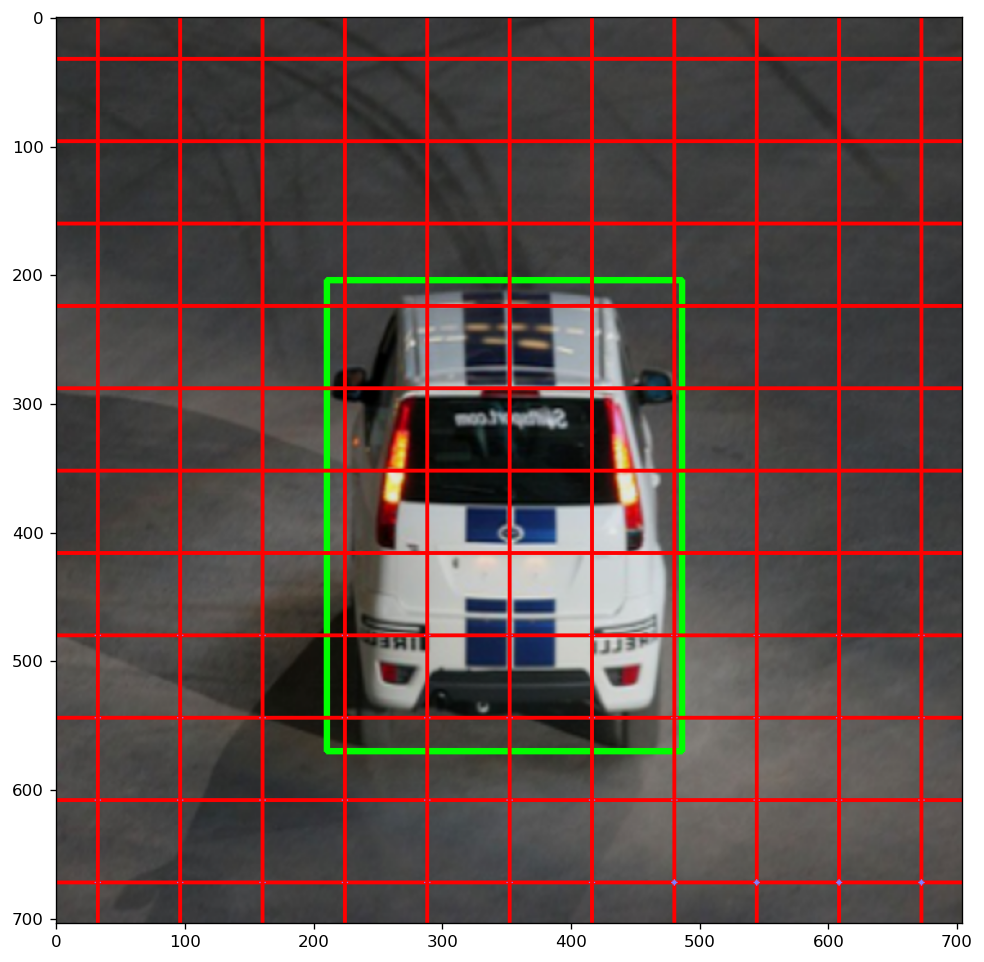

In [35]:
image, label = voc_train[0]
image, label = image[None, :].to(device), label.to(device)
fmap = net.rpn_backbone(image)
anchor = net.RPN.generate_anchor(fmap.shape)
anchor = cxcywh2xyxy(anchor)
_ = show_boxes(image, anchor[10::15], label[:, 2:])

In [25]:
"""第一阶段，RPN和rpn_backbone参与训练"""
train_rpn(net,
          cfg,
          'stage1',
          cfg.rpn_lr_stage_1,
          num_epochs=cfg.rpn_num_epochs_stage_1,
          update_backbone=True)
net.same_backbone = False

epoch    1, iter      206, loss=  0.0378
epoch    1, iter      411, loss=  0.0343
epoch    1, iter      616, loss=  0.0328
epoch    1, iter      821, loss=  0.0301
epoch    1, iter     1026, loss=  0.0297
epoch    2, iter     1231, loss=  0.0310
epoch    2, iter     1436, loss=  0.0289
epoch    2, iter     1641, loss=  0.0274
epoch    2, iter     1846, loss=  0.0259
epoch    2, iter     2051, loss=  0.0245
epoch    3, iter     2256, loss=  0.0280
epoch    3, iter     2461, loss=  0.0263
epoch    3, iter     2666, loss=  0.0255
epoch    3, iter     2871, loss=  0.0248
epoch    3, iter     3076, loss=  0.0237
epoch    4, iter     3281, loss=  0.0250
epoch    4, iter     3486, loss=  0.0246
epoch    4, iter     3691, loss=  0.0242
epoch    4, iter     3896, loss=  0.0229
epoch    4, iter     4101, loss=  0.0233
epoch    5, iter     4306, loss=  0.0203
epoch    5, iter     4511, loss=  0.0199
epoch    5, iter     4716, loss=  0.0196
epoch    5, iter     4921, loss=  0.0198
epoch    5, iter

In [26]:
"""第二阶段，Fast R-CNN和frcn_backbone参与训练"""
train_frcn(net,
           cfg,
           'stage2',
           cfg.frcn_lr_stage_2,
           num_epochs=cfg.frcn_num_epochs_stage_2,
           update_backbone=True)
net.same_backbone = False

tensor([1.2143, 3.5645, 3.4901, 5.3434, 2.9539, 5.0841, 3.9990, 4.2562, 1.7473,
        4.0051, 5.8760, 2.2244, 5.1064, 5.7239, 3.0060, 1.9826, 5.1290, 3.7320,
        4.8534, 4.7286, 1.0000], device='cuda:0')
epoch    1, iter      822, loss=  0.0572
epoch    1, iter     1643, loss=  0.0549
epoch    1, iter     2464, loss=  0.0539
epoch    1, iter     3285, loss=  0.0537


KeyboardInterrupt: 

In [ ]:
net.load_params(cfg.version)
net.rpn_backbone.load_state_dict(torch.load(f'models/{cfg.version}_frcn_backbone.pth'))
net.same_backbone = True

In [ ]:
"""第三阶段，仅更新RPN的参数"""
train_rpn(net,
          cfg,
          'stage3',
          cfg.rpn_lr_stage_3,
          num_epochs=cfg.rpn_num_epochs_stage_3,
          update_backbone=False)
net.same_backbone = True

In [ ]:
"""第四阶段，仅更新Fast R-CNN的参数"""
train_frcn(net,
           cfg,
           'stage4',
           cfg.frcn_lr_stage_4,
           num_epochs=cfg.frcn_num_epochs_stage_4,
           update_backbone=False)
net.same_backbone = True

In [ ]:
net.load_params(cfg.version)

In [ ]:
voc_dataset = PascalVOC2012(False)
for i in range(len(voc_dataset)):
    data = voc_dataset[i]
    img = show_predictions(net,
                           data,
                           proposal_iou_thres=0.3,
                           confidence_thres=0.8,
                           prediction_iou_thres=0.5,
                           scale=2.,
                           display=False)
    plt.imsave(f'./outputs/{cfg.version}/{i}.jpg', img)